In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from gPhoton.pipeline import execute_pipeline
from pyarrow import parquet

Pipeline steps:
1. ~Run photometry with extraction on NUV~
2. ~Run photometry with extraction on FUV~
3. ~Run photometry on FUV with NUV source positions~
4. ~Run photometry on NUV with FUV source positions~
5. ~Generate a merged catalog from NUV extractions~
6. ~Generate a merged catalog from FUV extractions~
7. Generate a merged catalog from all NUV & FUV detections

In [2]:
from glcat_merge_utils import *
from lightcurve_utils import *
from glcat_catalog_utils import *

In [3]:
metadata = parquet.read_table('metadata.parquet').to_pandas()

In [4]:
data = accumulate_run_data(23456,metadata=metadata)
ncat = make_catalog(data,'NUV')
fcat = make_catalog(data,'FUV')
cats = {'NUV':ncat,'FUV':fcat}

In [11]:
def crossmatch_catalogs(match_table, master_table, # match_table to master_table
                       ):
    master_catalog = SkyCoord(ra=master_table['RA'].values*u.degree,
                              dec=master_table['DEC'].values*u.degree)
    match_catalog = SkyCoord(ra=match_table['RA'].values*u.degree,
                             dec=match_table['DEC'].values*u.degree)
    catalog_ix, d2d, d3d = match_catalog.match_to_catalog_sky(master_catalog)
    #sep_constraint = d2d < match_radius * u.arcsec

    return catalog_ix,d2d

In [12]:
def xmatch(cats,
          bands = ('FUV','NUV'), # maps FUV -> NUV
          good_match_distance = 5, # arcseconds
          ):
    b0,b1 = bands
    mstr = f"{bands[0][0]}2{bands[1][0]}"

    idx,d2d=crossmatch_catalogs(cats[b0],cats[b1])
    match = pd.DataFrame({'idx':idx,'d2d':d2d,
                          'good_match':np.array(d2d <= good_match_distance * u.arcsec,dtype=int),
                          'best_match':np.zeros(len(idx),dtype=int),
                          'n_matches':np.zeros(len(idx),dtype=int),
                          'n_good_matches':np.zeros(len(idx),dtype=int)})
    for ix in np.unique(idx):
        best_ix = np.argmin(match.loc[match['idx']==ix]['d2d'].values)
        match.loc[match.loc[match['idx']==ix].iloc[best_ix].name,'best_match']=1
        match.loc[match['idx']==ix,'n_matches']=len(match.loc[match['idx']==ix])
        match.loc[match['idx']==ix,'n_good_matches']=len(match.loc[match['idx']==ix].loc[match['good_match']==1])
    
    # update the alternate-band catalog with the matches to this catalog
    cats[b0].loc[:,f'{mstr}_MATCH_INDEX']=np.full(len(cats[b0]),-1)
    cats[b0].loc[match.index,f'{mstr}_MATCH_INDEX']=np.array(match['idx'].values,dtype=int)

    cats[b0].loc[:,f'{mstr}_MATCH_DISTANCE']=np.full(len(cats[b0]),np.nan)
    cats[b0].loc[match.index,f'{mstr}_MATCH_DISTANCE']=(match['d2d'].values*60*60) # convert from degress to arcseconds

    cats[b0].loc[:,f'{mstr}_GOOD_MATCH_FLAG']=np.full(len(cats[b0]),-1)
    cats[b0].loc[match.index,f'{mstr}_GOOD_MATCH_FLAG']=np.array(match['good_match'].values,dtype=int)

    cats[b0].loc[:,f'{mstr}_BEST_MATCH_FLAG']=np.full(len(cats[b0]),-1)
    cats[b0].loc[match.index,f'{mstr}_BEST_MATCH_FLAG']=np.array(match['best_match'].values,dtype=int)
    
    # update this catalog with the reverse lookup to the "best" matches in the alternate-band catalog
    #    
    # the index in the FUV catalog of the nearest match aka "best match"
    cats[b1].loc[:,f'{mstr}_BEST_MATCH_INDEX']=np.full(len(cats[b1]),-1)
    cats[b1].loc[match['idx'][match['best_match']==1],
                f'{mstr}_BEST_MATCH_INDEX']=np.array(
                    match.loc[match['best_match']==1]['idx'].values,dtype=int)
    # this distance in decimal degress (?) to the nearest match aka "best match"
    cats[b1].loc[:,f'{mstr}_BEST_MATCH_DISTANCE']=np.full(len(cats[b1]),-1.0)
    cats[b1].loc[match['idx'][match['best_match']==1],
                f'{mstr}_BEST_MATCH_DISTANCE']=np.array(
                    match.loc[match['best_match']==1]['d2d'].values*60*60) # convert from degrees to arcseconds
    # it is possible that the "best match" is not a "good match" in which case this will be zero
    cats[b1].loc[:,f'{mstr}_GOOD_MATCH_COUNT']=np.full(len(cats[b1]),-1)
    cats[b1].loc[match['idx'][match['best_match']==1],
                f'{mstr}_GOOD_MATCH_COUNT']=np.array(
                    match.loc[match['best_match']==1]['n_good_matches'].values)
    # drop any duplicated columns (should just be ECLIPSE)
    for b in bands:
        cats[b] = cats[b].loc[:, ~cats[b].columns.duplicated()]
    return cats
%time cats=xmatch(cats,bands=('FUV','NUV'))
%time cats=xmatch(cats,bands=('NUV','FUV'))

CPU times: user 3.87 s, sys: 6.3 ms, total: 3.87 s
Wall time: 3.87 s
CPU times: user 3.82 s, sys: 5.84 ms, total: 3.83 s
Wall time: 3.83 s


/var/folders/jh/l3nkzcmx52zbg2p91vw7h27r0000gn/T/ipykernel_38127/1698008206.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats[b0].loc[:,f'{mstr}_MATCH_INDEX']=np.full(len(cats[b0]),-1)
/var/folders/jh/l3nkzcmx52zbg2p91vw7h27r0000gn/T/ipykernel_38127/1698008206.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats[b1].loc[:,f'{mstr}_BEST_MATCH_INDEX']=np.full(len(cats[b1]),-1)


In [62]:
cats['NUV'].to_csv('ncat_240616.csv',index=None)
cats['FUV'].to_csv('fcat_240616.csv',index=None)

[]

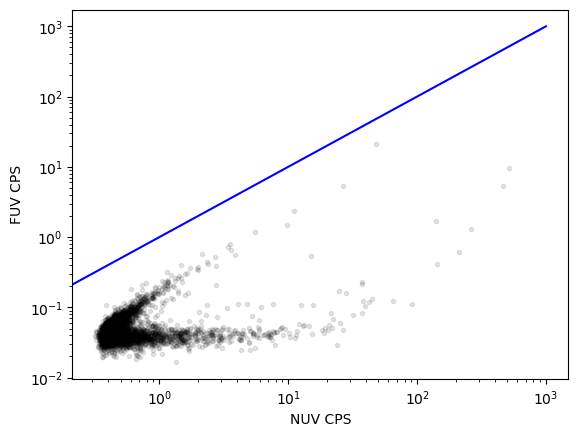

In [14]:
plt.plot(cats['NUV']['NUV_CPS_APER4'].values,cats['NUV']['FUV_CPS_APER4'].values,'k.',alpha=0.1)
plt.plot([0,1000],[0,1000],'b')
plt.xlabel('NUV CPS')
plt.ylabel('FUV CPS')

plt.loglog()

In [44]:
bg_cps_per_sqas = (cats['NUV']['NUV_CPS_APER6'].values-cats['NUV']['NUV_CPS_APER5'])/(np.pi*(17.3**2-12.8**2))
bg_cps_per_sqas.values[10]

0.0014185350454480252

[]

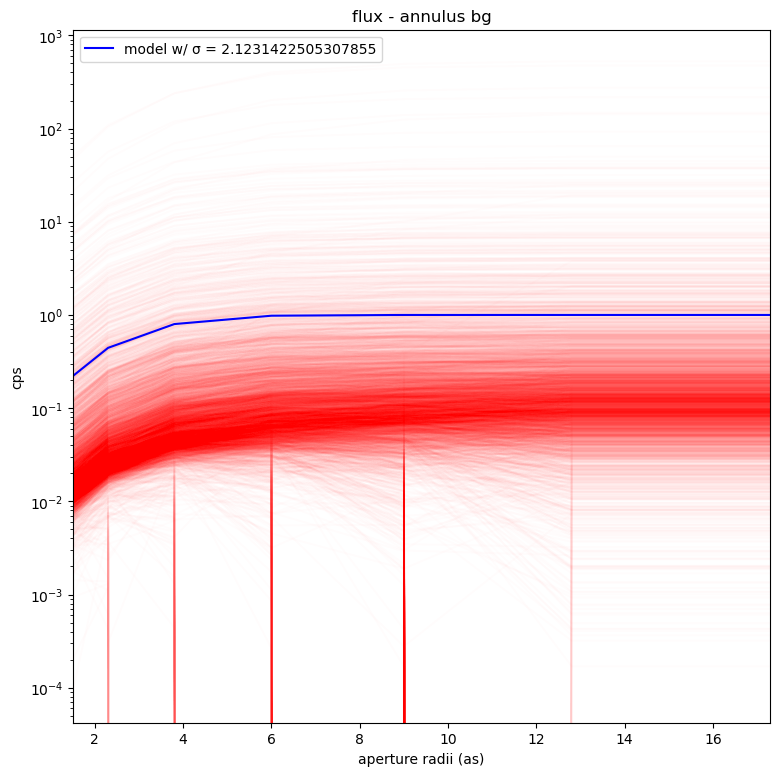

In [61]:
aperture_radii = np.array([1.5, 2.3, 3.8, 6.0, 9.0, 12.8, 17.3])
plt.figure(figsize=(9,9))
for i in range(len(cats['NUV'])):
    plt.plot(aperture_radii,
             [cats['NUV'][f'NUV_CPS_APER{a}'].iloc[i]-
              bg_cps_per_sqas[i]*np.pi*r**2
              for a,r in enumerate(aperture_radii)],
             'r-',alpha=0.01)
#for i in range(len(cats['NUV'])):
#    plt.plot(aperture_radii,
#             [cats['NUV'][f'FUV_CPS_APER{r}'].iloc[i] for r in range(7)],'b-',alpha=0.01)

def gaussian_flux_fraction(r, sigma):
    return 1 - np.exp(-r**2 / (2 * sigma**2))

sigma_values = np.array([5/2.355]) # mission quotes 5" FWHM
#sigma_values = np.arange(5/2.355,40,1)
for sigma in sigma_values:
    flux_fractions = gaussian_flux_fraction(aperture_radii, sigma)
    plt.plot(aperture_radii, flux_fractions, 'b-', label=f'model w/ σ = {np.round(sigma,2)}')

plt.title('flux - annulus bg')
plt.xlabel('aperture radii (as)')
plt.ylabel('cps')
plt.legend()

plt.xlim([1.5,17.3])
plt.semilogy()